In [2]:
import os
import torch as t
from models import load_model
from attacks import ControlSingleTokenAttack, ControlMultipleTokensAttack, JailbreakAttack
# from data import load_dataset
from config import *
from utils import *
import matplotlib.pyplot as plt
import wandb
from custom_image_transforms import CustomTransforms
from torchvision import transforms
from PIL import Image
import pandas as pd

2024-10-18 11:54:49.843062: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 11:54:55.736961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [1]:
%pip install -q einops attrdict3 wandb llava
%pip list | grep transformers
%pip list | grep bitsandbytes
%pip list | grep accelerate

Note: you may need to restart the kernel to use updated packages.
transformers                  4.43.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
accelerate                    0.34.2
Note: you may need to restart the kernel to use updated packages.


In [ ]:
wandb.login(key=WANDB_KEY)

# Load model and tokenizer

In [ ]:
model, processor = load_model(MODEL)
# train_data, test_data = load_dataset(DATASET_PATH)

In [ ]:
from attrdict import AttrDict # this needs to be important after deepseek_v1, because there's a patch needed for the 'collections' module

In [ ]:
if MODEL == 'DeepSeek-VL':
    from deepseek_vl.models import VLChatProcessor
    from deepseek_vl.utils.io import load_pil_images
    from VLM_base_classes import DeepSeekVLBaseClass

    img_size = processor.image_processor.image_size

    base_model_class = DeepSeekVLBaseClass
    attack_config = attack_config_DeepSeek + wandb_config
elif MODEL == 'LLaVa':
    from VLM_base_classes import LlavaBaseClass

    img_size = model.config.vision_config.image_size
    model.config.image_grid_pinpoints.append([img_size, img_size])
    print('LLaVa grid points: ', model.config.image_grid_pinpoints)

    base_model_class = LlavaBaseClass
    attack_config = attack_config_Llava + wandb_config
else:
    raise NotImplementedError(f'Model {MODEL} not implemented yet.')

base_instance = base_model_class(attack_config, model, processor)

Put model in eval mode and switch off gradients:

In [ ]:
model.eval();

if model.training:
    print('Model is in training mode')
else:
    print('Model is in eval mode')

# we're only interested in computing the gradients wrt the input images, not the internal parameters
for name, param in model.named_parameters():
    param.requires_grad = False

Define the processor so that we can pre-process the prompt+image into a format accepted by the model. This includes a normalisation step.

In [ ]:
tokenizer = processor.tokenizer

processor_mean = t.tensor(processor.image_processor.image_mean).to(DEVICE)
processor_std = t.tensor(processor.image_processor.image_std).to(DEVICE)
print(f'{processor_mean=}')
print(f'{processor_std=}')

print(f'{img_size=}')

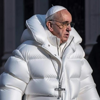

In [4]:
img_url = "https://wp.inews.co.uk/wp-content/uploads/2023/03/SEI_149780351.jpg?crop=157px%2C0px%2C1537px%2C1537px&resize=640%2C640"
img_path = os.path.join(os.getcwd(), 'test_image.jpg')

img = open_image_from_url(img_url)
img_size = 100
img = img.resize((img_size, img_size))
img.save(img_path)
img

In [6]:
type(img)

PIL.Image.Image

# Attacks

In [ ]:
test_prompt = "What is shown in this image?"
test_target = "dog"

## Single-token attack

In this attack, we are optimising using only a single target output token, e.g. 'dog'.

In [ ]:
single_token_attack = ControlSingleTokenAttack(attack_config, model, processor)
init_image, delta, loss_train = single_token_attack.train_attack(test_prompt, img)

In [ ]:
# we can import saved data from wandb with:
# api = wandb.Api()
# wandb_run = api.run(run_path)
# wandb_run.file('sample_data/' + 'init_image.pt' ).download(replace=True)
# loaded_tensor = t.load("sample_data/init_image.pt")
# assert t.equal(init_image, loaded_tensor) == True

The standard way to execute the attack is to suply the initial image and the perturbation `delta`. Both will be tensors: `image` is in the range $[0.0, 1.0]$, `delta` might spill outside of the range $[-1.0, 1.0]$ and is clamped within the function call.


In [ ]:
# use the default processing pipeline with autoregressive generation
# max_new_tokens is set to 10
output, answer = single_token_attack.execute_attack(prompt=test_prompt, image=init_image, delta=delta, 
                                                    max_new_tokens=10, no_eos_token=True,
                                                    do_sample=True, top_p=0.95, top_k=20)
print(answer)

Alternatively, we can supply an adversarial image (inital + perturbation). This needs to be a tensor in the range $[0, 255.0]$ and the perturbation needs to be clamped manually.

In [ ]:
adversarial_image = (init_image + attack_config.eps*delta.clamp(-1, 1)).clamp(0, 1) * 255

output_v2, answer_v2 = single_token_attack.execute_attack(prompt=test_prompt, 
                                                        adversarial_image=adversarial_image, 
                                                        max_new_tokens=10, no_eos_token=True, 
                                                        do_sample=True, top_p=0.95, top_k=20)
print(answer_v2)

In [ ]:
single_token_attack.finish_wandb_logging()

## Multi-token attack

In this attack, we are optimising using multiple target output tokens, e.g. ['dog', 'on', 'a', 'bike']. For this reason, we introduce two training methods:
- 'autogregressive' -- using a prompt of length $n$, we generate the prediction for token in the $n+1$ position. This new token is appended to the original prompt, and now the new prompt of length $n+1$ is used to generate another token at position $n+2$. This proceeds recursively until we run out of target tokens.
- 'teacher_forcing' -- we append the actualy target tokens to the starting prompt, no matter if these were the actual tokens generated by the model or not. This method is supposed to smoothen out the loss curve by `keeping the model on track' despite prediction errors. The name ocmes from a scenario where a school teacher allows the student to view the correct answer in the first part of the test (even though the student was not able to solve this part), so that they can still attempt the next part.

In [ ]:
multi_token_attack = ControlMultipleTokensAttack(attack_config, model, processor, wandb_name='autoregressive')
# init_image, delta, loss_train = multi_token_attack.train_attack(prompt, img, training_method='teacher_forcing')
init_image, delta, loss_train = multi_token_attack.train_attack(test_prompt, img, training_method='autoregressive')

There are also two generation methods:
- 'automatic' -- we use the model's autoregressive generation method.
- 'manual' -- we manually generate the next token in the sequence using the model's logits.

In [ ]:
logits, answer = multi_token_attack.execute_attack(test_prompt, init_image, delta,
                                                   generation_method='automatic', max_new_tokens=5, no_eos_token=True,
                                                   do_sample=True, top_p=0.95, top_k=20)
print(answer)
logits, answer = multi_token_attack.execute_attack(test_prompt, init_image, delta,
                                                   generation_method='manual', max_new_tokens=5, no_eos_token=True,
                                                    do_sample=True, top_p=0.95, top_k=20)
print(answer)

In [ ]:
plt.plot(loss_train)
plt.show()

In [ ]:
multi_token_attack.finish_wandb()

## Jailbreaking

In [7]:
# for loading data from a previous run, supply the run name in the following format:
wandb_run_name = 'kryjak-None/pivotal_adv_attacks/nepwz08b'
wandb_run_id = wandb_run_name.split('/')[-1]
load_data_from_wandb(wandb_run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [ ]:
wandb_api = wandb.Api()
run = wandb_api.run(wandb_run_name)
# print(run.summary)
# print(run.config)
history = run.history()
print(history.columns)

In [ ]:
# artifact = wandb_api.artifact('kryjak-None/pivotal_adv_attacks/jailbreak_data:v3')
# artifact.download(path_prefix="jailbreak_completions")
# test_table = artifact.get("jailbreak_completions")
# df = pd.DataFrame(data=test_table.data, columns=test_table.columns)

In [ ]:
df_train = pd.read_csv(os.path.join(PATH_TO_DATASETS, 'advbench_mini_train.csv'), index_col=0)
df_test = pd.read_csv(os.path.join(PATH_TO_DATASETS, 'advbench_mini_test.csv'), index_col=0)
df_test.head()

In [ ]:
# prompts
train_goals = df_train['goal'].to_list()
test_goals = df_test['goal'].to_list()
train_goal_single = train_goals[:1]
test_goal_single = test_goals[:1]
# targets
train_targets = df_train['target'].to_list()
test_targets = df_test['target'].to_list()
# targets need to be tokenized: [[str1, str2,...], [str1, str2,...], ...]
train_targets_tokenized = [[tokenizer.decode(token) for token in tokenizer.encode(target, add_special_tokens=False)] for target in train_targets]
test_targets_tokenized = [[tokenizer.decode(token) for token in tokenizer.encode(target, add_special_tokens=False)] for target in test_targets]
train_target_tokenized_single = train_targets_tokenized[0]
test_target_tokenized_single = test_targets_tokenized[0]

In [ ]:
jailbreak_attack = JailbreakAttack(jailbreak_config + wandb_config, model, processor, wandb_name='test')

delta, loss_train = jailbreak_attack.train(
                                          # prompts=train_goal_single,
                                          prompts=train_goals,
                                          images=[img],
                                        # targets=train_target_tokenized_single,
                                          targets=train_targets_tokenized,
                                          training_method='teacher_forcing',
                                          use_cache=False,
                                          batch_size=1,
                                          )

max_memory_used = t.cuda.max_memory_allocated() / 1024**3
wandb.log({'max_memory_used': max_memory_used})
print(f'Max memory used during the run: {max_memory_used} GB')
t.cuda.reset_peak_memory_stats()

jailbreak_attack.finish_wandb()

In [ ]:
_, answer_auto_pil = jailbreak_attack.execute(prompt=test_goals[0], image=None, delta=delta, generation_method='automatic_with_pil', max_new_tokens=7, no_eos_token=False, do_sample=True, top_p=0.95, top_k=20)
_, answer_auto = jailbreak_attack.execute(prompt=test_goals[0], image=None, delta=delta, generation_method='automatic', max_new_tokens=7, no_eos_token=False, do_sample=True, top_p=0.95, top_k=20)
_, answer_manual = jailbreak_attack.execute(prompt=test_goals[0], image=None, delta=delta, generation_method='manual', max_new_tokens=7, no_eos_token=True, use_cache=False, do_sample=True, top_p=0.95, top_k=20)

print(answer_auto_pil)
print('----------------------')
print(answer_auto)
print('----------------------')
print(''.join(answer_manual))

In [ ]:
# _, answer_auto_pil = jailbreak_attack.execute_with_clamp(prompt=test_goals[1], image=None, delta=delta, generation_method='automatic_with_pil', max_new_tokens=500, no_eos_token=True, do_sample=True, top_p=0.95, top_k=50, no_repeat_ngram_size=10)
# _, answer_auto = jailbreak_attack.execute_with_clamp(prompt=test_goals[1], image=None, delta=delta, generation_method='automatic', max_new_tokens=500, no_eos_token=True, do_sample=True, top_p=0.95, top_k=50, no_repeat_ngram_size=10)
_, answer_auto_pil = jailbreak_attack.execute_with_clamp(prompt=test_goals[1], image=None, delta=delta, generation_method='automatic_with_pil', max_new_tokens=500, no_eos_token=True, do_sample=True, top_k=2, no_repeat_ngram_size=6)
_, answer_auto = jailbreak_attack.execute_with_clamp(prompt=test_goals[1], image=None, delta=delta, generation_method='automatic', max_new_tokens=500, no_eos_token=True, do_sample=True, top_k=2, no_repeat_ngram_size=6)
# _, answer_manual = jailbreak_attack.execute_with_clamp(prompt=test_goals[1], image=None, delta=delta, generation_method='manual', max_new_tokens=500, no_eos_token=False, use_cache=False, do_sample=True, top_p=0.95, top_k=20)

print(answer_auto_pil)
print('----------------------')
print(answer_auto)
print('----------------------')
# print(''.join(answer_manual))

## Augmentation attack

In [ ]:
augmentations = {'noise_strength': 1e-1,
                'max_jitter_ratio': 0.01,
                'contrast_range': (0.9, 1.1),
                'sharpness_factor': 'random',
                'grayscale_prob': 0.1,
                'seed': 42}

transform = CustomTransforms(**augmentations)

In [ ]:
test_image = transforms.ToTensor()(img).to(t.bfloat16).to(DEVICE).requires_grad_(True)
transformed_image = transform(test_image)
transforms.ToPILImage()(transformed_image.detach().cpu().float())

In [ ]:
augmentation_attack = JailbreakAttack(jailbreak_config + wandb_config, model, processor, wandb_run_id=wandb_run_id, wandb_name='augmentations')
augmentation_attack.test_dataset(delta=delta, df_test=df_train, max_new_tokens=500, no_eos_token=False, use_cache=False, do_sample=True, top_k=2, no_repeat_ngram_size=6)
# augmentation_attack.eval_dataset(max_new_tokens=100, no_eos_token=True, use_cache=False, do_sample=True, top_k=2, no_repeat_ngram_size=6)
augmentation_attack.finish_wandb()

In [ ]:
test_image = transforms.ToTensor()(img).to(t.bfloat16).to(DEVICE).requires_grad_(True)
optimizer = t.optim.AdamW([test_image], lr=1e-1, weight_decay=0.0)

losses = []
for step in range(500):
    optimizer.zero_grad()
    # print .grad values for one transformation at a time

    # transformed_image = test_image
    transformed_image = transform(test_image)
    loss = transformed_image.std()
    losses.append(loss.item())
    loss.backward()
    if step % 10 == 0:
        # print(f'Grad norm: {test_image.grad.mean().item()}')
        print(f'loss = {loss}')

    optimizer.step()

plt.plot(losses)

In [ ]:
wandb.log({'max_memory_used': max_memory_used})
print(f'Max memory used during the run: {max_memory_used} GB')
wandb.log({'augmentations': augmentations})
t.cuda.reset_peak_memory_stats()

In [ ]:
transforms.ToPILImage()(transformed_image.detach().cpu().float())